In [1]:
# Notebook to explore more serious convolutional networks 
# i.e. includes analysis of training and test accuracies

In [2]:
# Tried a few things:
# More convolution layers did not increase accuracy
# BatchNorm helps the training initialy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from core_functions import SensorSignals

# Model with usual halving of image size and doubling the depth
class CNN_STANDARD(nn.Module):    
    def __init__(self):
        super(CNN_STANDARD, self).__init__()

        self.conv = nn.Sequential(    # Convolutional part, 3 layers
            nn.Conv1d(1, 4, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(4, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(        # Fully connected part, 3 layers
            nn.Linear(16 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 3)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x


class CNN_2(nn.Module):    
    def __init__(self):
        super(CNN_2, self).__init__()

        self.conv = nn.Sequential(    # Convolutional part, 3 layers
            nn.Conv1d(1, 8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Conv1d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(        # Fully connected part, 3 layers
            nn.Linear(32 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 3)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x


class CNN_3(nn.Module):    
    def __init__(self):
        super(CNN_3, self).__init__()

        self.conv = nn.Sequential(    # Convolutional part, 3 layers
            nn.Conv1d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(        # Fully connected part, 3 layers
            nn.Linear(64 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 3)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

    
class CNN_5(nn.Module):    
    def __init__(self):
        super(CNN_5, self).__init__()

        self.conv = nn.Sequential(    # Convolutional part, 3 layers
            nn.Conv1d(1, 4, kernel_size=3, stride=2, padding=1),
            nn.Conv1d(4, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(4),
            nn.ReLU(),
            nn.Conv1d(4, 8, kernel_size=3, stride=2, padding=1),
            nn.Conv1d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Conv1d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.Conv1d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(        # Fully connected part, 3 layers
            nn.Linear(16 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 3)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [2]:
dataPath = "./second_collection_triggs_rels_32.npz"
S = SensorSignals(dataPath) 
S.split_data()
S.norm_X()
S.setup_tensors()
S.print_shapes()

# for CNN_STANDARD
# lr=5e-3, wd=1e-4

# with BatchNorm1d
# lr=1e-2, wd=1e-3

models = [CNN_2(), CNN_3()]
lr = 1e-2
wd = 1e-3
bs = 128
max_epochs = 50
S.train_multiple_models(models, learning_rate=lr, weight_decay=wd, batch_size=bs, max_epochs=max_epochs)

Before: 3.045220350877193
Normalizing dataset by 3.05
After: 1.0
Before: 3.0533344594594594
Normalizing dataset by 3.05
After: 1.0026645390636277
Before: 3.0294538232373385
Normalizing dataset by 3.05
After: 0.9948225330770193
Using Device:  cpu , dtype:  torch.float32
Raw data shape:  (7891, 1, 32)
Labels shape:  (7891,)
Unique labels:  [0 1 2]
Shape of test set: (1184, 1, 32)
Shape of train set: (5700, 1, 32)
Shape of validation set: (1007, 1, 32)
Fraction of single class in test set:  0.2981418918918919
Epoch 1, Batch 1: loss=1.300, train=54.1%, val=56.3%
Epoch 2, Batch 1: loss=0.487, train=78.7%, val=80.4%
Epoch 3, Batch 1: loss=0.397, train=83.0%, val=83.8%
Epoch 4, Batch 1: loss=0.533, train=81.6%, val=83.5%
Epoch 5, Batch 1: loss=0.447, train=86.1%, val=86.9%
Epoch 6, Batch 1: loss=0.354, train=86.1%, val=87.7%
Epoch 7, Batch 1: loss=0.369, train=86.4%, val=86.6%
Epoch 8, Batch 1: loss=0.285, train=87.4%, val=89.0%
Epoch 9, Batch 1: loss=0.357, train=88.3%, val=88.2%
Epoch 10, B

Accuracy of test set of best model (idx=1): 90.0%


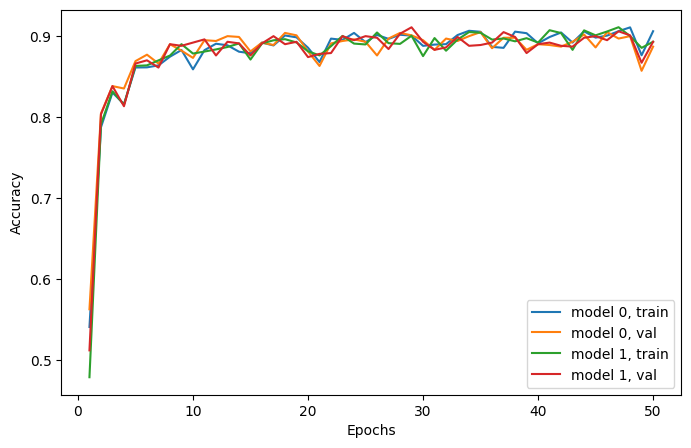

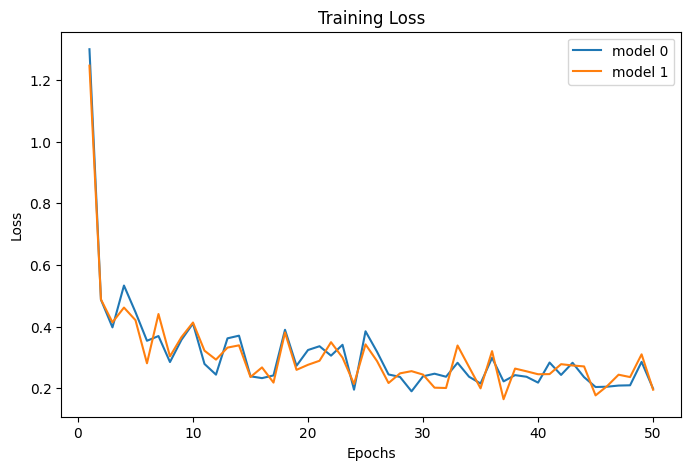

In [3]:
S.plotAcc()
S.plotLosses()
S.bestModelAcc()

In [1]:
from core_functions import SensorSignals
import torch.nn as nn

D = SensorSignals("./second_collection_triggs_rels_32.npz", n_channels=3) 
D.split_data()
D.norm_X()
D.setup_tensors()
D.print_shapes()

class CNN_7(nn.Module):    
    def __init__(self):
        super(CNN_7, self).__init__()

        self.conv = nn.Sequential(    # Convolutional part, 3 layers
            nn.Conv1d(3, 8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Conv1d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(        # Fully connected part, 3 layers
            nn.Linear(32 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 3)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

models = [CNN_7()]
D.train_multiple_models(models, learning_rate=1e-2, weight_decay=1e-3, batch_size=128, max_epochs=50)

Before: 3.0698450749711648
Normalizing dataset by 3.07
After: 1.0000000000000002
Before: 3.0674299259259263
Normalizing dataset by 3.07
After: 0.9992132667980772
Before: 3.072794858387799
Normalizing dataset by 3.07
After: 1.0009608899943143
Using Device:  cpu , dtype:  torch.float32
Raw data shape:  (30000, 3, 32)
Labels shape:  (30000,)
Unique labels:  [0 1 2]
Shape of test set: (4500, 3, 32)
Shape of train set: (21675, 3, 32)
Shape of validation set: (3825, 3, 32)
Fraction of single class in test set:  0.33111111111111113
Epoch 1, Batch 1: loss=1.310, train=59.1%, val=58.8%
Epoch 1, Batch 101: loss=0.239, train=91.3%, val=90.7%
Epoch 2, Batch 1: loss=0.211, train=94.1%, val=93.6%
Epoch 2, Batch 101: loss=0.179, train=94.9%, val=94.4%
Epoch 3, Batch 1: loss=0.169, train=94.7%, val=94.0%
Epoch 3, Batch 101: loss=0.164, train=95.6%, val=95.1%
Epoch 4, Batch 1: loss=0.147, train=94.2%, val=93.6%
Epoch 4, Batch 101: loss=0.225, train=95.9%, val=95.8%
Epoch 5, Batch 1: loss=0.236, train=9

Accuracy of test set of best model (idx=0): 96.2%


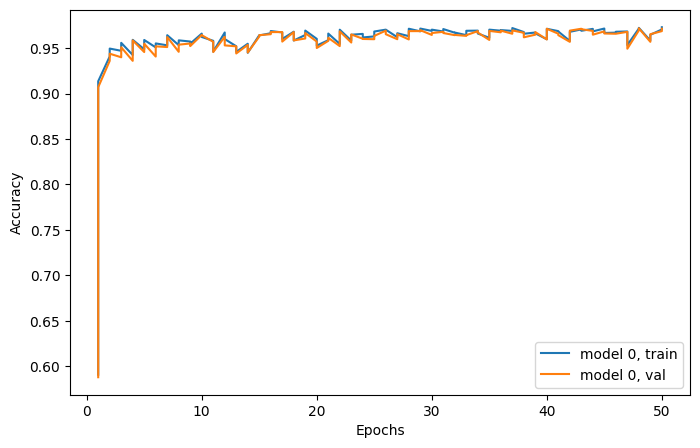

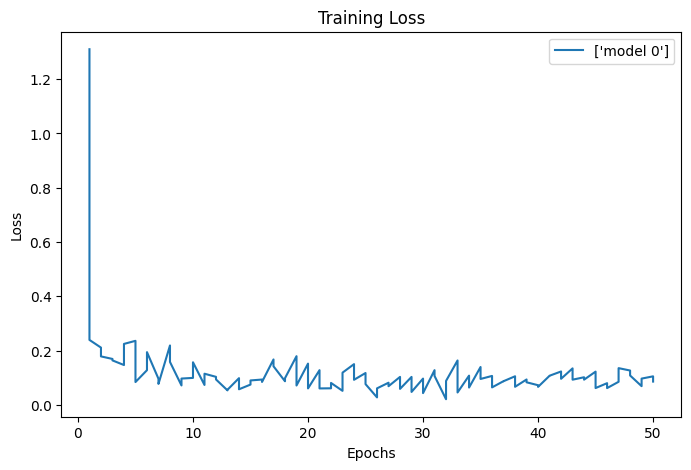

In [3]:
D.plotAcc()
D.plotLosses()
D.bestModelAcc()